**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
import seaborn as sns
pd.options.mode.chained_assignment = None

from pyod.models.iforest import IForest
from pyod.utils.data import generate_data

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

**Read The Data**

In [2]:
Dataurl = 'https://query.data.world/s/nggbbnqqm2kolsk5dragqhieyrkxrf'
df = pd.read_csv(Dataurl, delimiter=';')
df.head(n=10)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN
5,771035,2632,930102,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
6,452728,1539,930103,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
7,725751,2484,930103,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
8,497211,1695,930103,PRIJEM,VKLAD,200.0,200.0,NaN,NaN,NaN
9,232960,793,930103,PRIJEM,VKLAD,800.0,800.0,NaN,NaN,NaN


**General Information On The Data**

In [3]:
df.info()
print ('\n')
print('The data contains 1,056,320 rows and 10 columns')
print ("""Some columns contain null values. However, the columns we will use 
        (account_id, date, type, and amount) do not contain null values""")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  int64  
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 80.6+ MB


The data contains 1,056,320 rows and 10 columns
Some columns contain null values. However, the columns we will use 
        (account_id, date, type, and amount) do not contain null values


**Filter Out The Needed Columns And Describe The Data**

In [4]:
df_needed = df[["account_id", "date", "type", "amount"]]
df_needed.describe()

,account_id,date,amount
count,1.056320e+06,1.056320e+06,1.056320e+06
mean,2.936867e+03,9.656748e+05,5.924146e+03
std,2.477345e+03,1.394535e+04,9.522735e+03
min,1.000000e+00,9.301010e+05,0.000000e+00
25%,1.204000e+03,9.601160e+05,1.359000e+02
50%,2.434000e+03,9.704100e+05,2.100000e+03
75%,3.660000e+03,9.802280e+05,6.800000e+03
max,1.138200e+04,9.812310e+05,8.740000e+04


The account_id and amount are the only columns that show up
            In the description table above because, they are the only numeric
            columns in the df_needed DataFrame

**We Need To Format The Dates Nicely**

In [5]:
df_needed['date'] = pd.to_datetime(df['date'], format='%y%m%d')
df_needed.head(n=5) #Shows the formated date column

,account_id,date,type,amount
0,2378,1993-01-01,PRIJEM,700.0
1,576,1993-01-01,PRIJEM,900.0
2,704,1993-01-01,PRIJEM,1000.0
3,3818,1993-01-01,PRIJEM,600.0
4,1972,1993-01-02,PRIJEM,400.0


**Plot Of The Distribution Of The Amount**

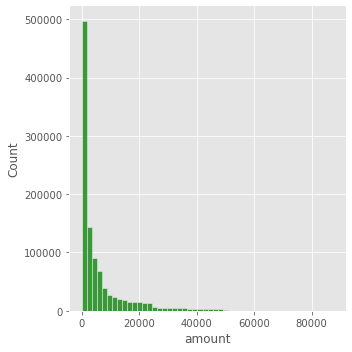

In [6]:
sns.displot(df,x='amount',bins=50,color='g')
plt.show()

**We Need To Rename PRIJEM, VYDAJ And VYBER From The Type Column Into English Words**

In [7]:
rename = {'PRIJEM':'CREDIT', 'VYDAJ':'DEBIT','VYBER':'NOT SURE'}
df_needed['type'] = df_needed['type'].replace(rename)
df_needed.head(n=5)

,account_id,date,type,amount
0,2378,1993-01-01,CREDIT,700.0
1,576,1993-01-01,CREDIT,900.0
2,704,1993-01-01,CREDIT,1000.0
3,3818,1993-01-01,CREDIT,600.0
4,1972,1993-01-02,CREDIT,400.0


**Graphical Representation Of The Frequency Each Transaction Type Occurs**

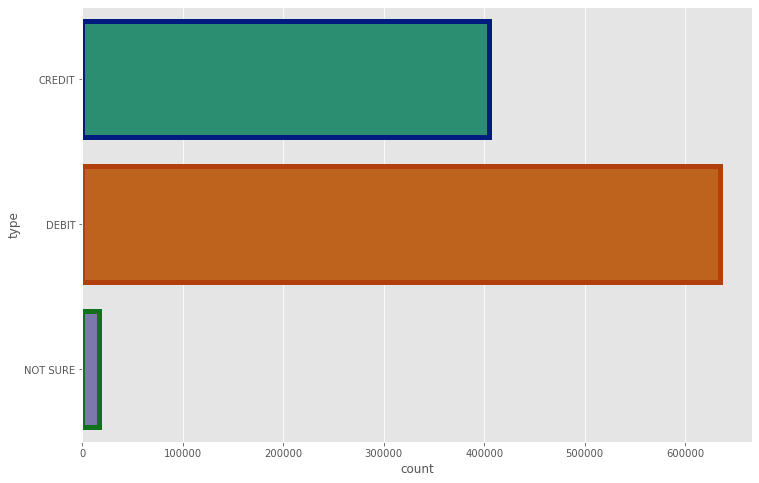

In [8]:
sns.countplot(y="type", data=df_needed,
                    palette='Dark2',
                    linewidth=5,
                    edgecolor=sns.color_palette("dark", 3))

plt.show()

**Only Debit Transactions Are Extracted, And The Results Sorted by account_id And date, While The Results are Index By date**

In [9]:
df_debits = df_needed.query('type == "DEBIT"').sort_values(by=['account_id', 'date']).set_index('date')

df_debits.head(n=10)

,account_id,type,amount
date,,,
1995-06-22,1,DEBIT,200.0
1995-07-22,1,DEBIT,5300.0
1995-08-21,1,DEBIT,7500.0
1995-08-31,1,DEBIT,14.6
1995-09-05,1,DEBIT,2452.0
1995-09-20,1,DEBIT,700.0
1995-09-30,1,DEBIT,14.6
1995-10-05,1,DEBIT,2452.0
1995-10-20,1,DEBIT,2900.0


**Additional Columns Are Created For Sum Of The Previous 5 Days Transaction Amount, And The Count Of The Previous 5 Days Transactions** 

In [10]:
# get the sum of the previous 5 days transaction amounts.
df_debits['sum_5days'] = df_debits.groupby('account_id')['amount'].transform(lambda o: o.rolling(timedelta(days=5)).sum())
# get the count of the previous 5 days transactions.
df_debits['count_5days'] = df_debits.groupby('account_id')['amount'].transform(lambda o: o.rolling(timedelta(days=5)).count())
df_debits.head(n=20)

,account_id,type,amount,sum_5days,count_5days
date,,,,,
1995-06-22,1,DEBIT,200.0,200.0,1.0
1995-07-22,1,DEBIT,5300.0,5300.0,1.0
1995-08-21,1,DEBIT,7500.0,7500.0,1.0
1995-08-31,1,DEBIT,14.6,14.6,1.0
1995-09-05,1,DEBIT,2452.0,2452.0,1.0
1995-09-20,1,DEBIT,700.0,700.0,1.0
1995-09-30,1,DEBIT,14.6,14.6,1.0
1995-10-05,1,DEBIT,2452.0,2452.0,1.0
1995-10-20,1,DEBIT,2900.0,2900.0,1.0


It is observed from the table above that a total withdrawal of 2662.0 CZK was made twice 04/01/1996 to 05/01/1996

**Define The Anomaly Proportion, Create The Model, Fit The Model To Our Data That Has No Label** 

In [11]:
#Set the anomaly proportion to 0.5 percent
anomaly_proportion = 0.005

# train IForest detector
Model_name = 'Anomaly Detection In Bank Data (Isolation Forest)'
Model = IForest(contamination=anomaly_proportion)

X = df_debits[['count_5days', 'sum_5days']]
#Fit the model to the data
Model.fit(X)

# get the prediction labels and outlier scores of the training data
# Binary labels 0 represents inliers, 1 represents outliers
df_debits['y_pred'] = Model.labels_ 

# Raw outlier scores. Hence, the bigger the number the greater the anomaly.
df_debits['y_scores'] = Model.decision_scores_ 

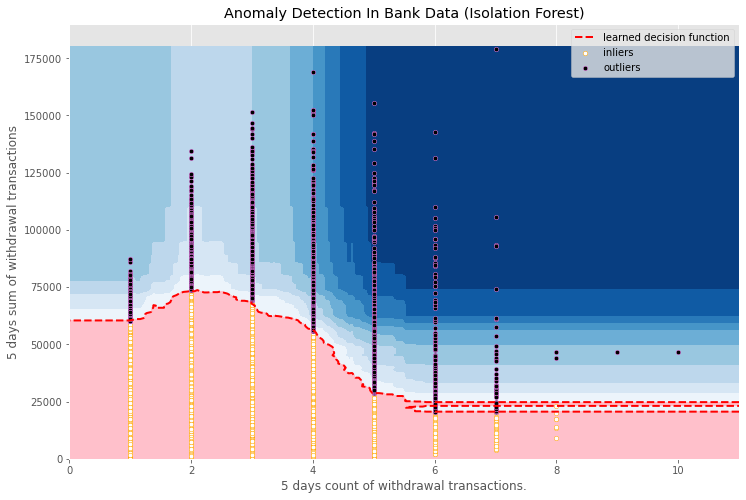

In [12]:
xx , yy = np.meshgrid(np.linspace(0, 11, 200), np.linspace(0, 180000, 200))

# Decision function calculates the raw anomaly score for every point
Z = Model.decision_function(np.c_[xx.ravel(), yy.ravel()])*-1
Z = Z.reshape(xx.shape)


threshold = (df_debits.loc[df_debits['y_pred'] == 1, 'y_scores'].min()*-1)/2 + (df_debits.loc[df_debits['y_pred'] == 0, 'y_scores'].max()*-1)/2

#Set size of the subplot
subplot = plt.subplot(1, 1, 1)

#Set the background colour of outliers
subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10), cmap=plt.cm.Blues_r)

#Set colour of the boundary between inliers and outliers
a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

#Set the background colour of inliers
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='pink')


msk = df_debits['y_pred'] == 0
x = df_debits.loc[msk, ['count_5days', 'sum_5days']].values

#Set inliners colour
b = subplot.scatter(x[:, 0], x[:, 1], c='white',s=20, edgecolor='orange') 


msk = df_debits['y_pred'] == 1
x = df_debits.loc[msk, ['count_5days', 'sum_5days']].values

#Set outliers colour
c = subplot.scatter(x[:, 0], x[:, 1], c='black',s=20, edgecolor='violet')
subplot.axis('tight')

#Create the legend
subplot.legend(
    [a.collections[0], b, c],
    ['learned decision function', 'inliers', 'outliers'],
    prop=matplotlib.font_manager.FontProperties(size=10),
    loc='best')

subplot.set_title(Model_name)
subplot.set_xlim((0, 11))
subplot.set_ylim((0, 190000))

subplot.set_xlabel("5 days count of withdrawal transactions.")
subplot.set_ylabel("5 days sum of withdrawal transactions")
plt.show()

The yellow marker represent the inliers, violet marker represent outliers, red marker represent the boundary between the inliers and the outliers